# COVID-19 Analysis

## Preliminaries

In [1]:
%matplotlib inline
# produce vector inline graphics
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tempfile
import requests
import zipfile
import datetime
from pathlib import Path
from IPython.display import display, Markdown
from functools import reduce
import humanize

In [2]:
print(f"Generated on {datetime.datetime.utcnow()} UTC")

Generated on 2021-11-29 10:19:27.261890 UTC


## Data retrieval
### Get OurWorldInData data

In [3]:
df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
df.index = pd.to_datetime(df.date)
df["death_ratio"] = df.new_deaths_smoothed_per_million / df.new_cases_smoothed_per_million

### French data

In [4]:
fr_dep_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/5c4e1452-3850-4b59-b11c-3dd51d7fb8b5")
fr_dep_df.index = pd.to_datetime(fr_dep_df.date, utc=True)

fr_df = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617")
fr_df.index = pd.to_datetime(fr_df.date, utc=True)

/home/pagessin/dev/covid19/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Swiss data

In [7]:
r = requests.get("https://www.covid19.admin.ch/api/data/context", timeout=10)
url = r.json()["sources"]["zip"]["csv"]
# print(url)

with tempfile.TemporaryDirectory() as d:
    dl = Path(d) / "dl.zip"
#     print(dl.resolve())
    with requests.get(url, stream=True, timeout=10) as r:
        with dl.open("wb") as fh:
            r.raise_for_status()
            for chunk in r.iter_content(chunk_size=8192): 
                fh.write(chunk)

    with zipfile.ZipFile(fh.name) as z:
        with z.open("data/COVID19Cases_geoRegion.csv") as fh:
            ch_df = pd.read_csv(fh)
            
        with z.open("data/COVID19HospCapacity_geoRegion.csv") as fh:
            ch_icu_df = pd.read_csv(fh)
            
ch_df.index = pd.to_datetime(ch_df.datum, utc=True)
ch_icu_df.index = pd.to_datetime(ch_icu_df.date)

# ch_icu_df = ch_icu_df[ch_icu_df.geoRegion == "CH"]
ch_icu_df = ch_icu_df[["geoRegion", "ICU_Covid19Patients", "ICU_NonCovid19Patients", "ICU_FreeCapacity"]]
ch_icu_df.columns = ["canton", "used_covid", "used_non_covid", "free"]

### German data

In [45]:
ger_inc_df = pd.read_csv("https://rki-wrap.dokku.paulgessinger.com")
ger_inc_df.index = pd.to_datetime(ger_inc_df.date, utc=True)

In [38]:
raw_ger_inc_df = pd.read_csv("https://opendata.arcgis.com/api/v3/datasets/ef4b445a53c1406892257fe63129a8ea_0/downloads/data?format=csv&spatialRefId=4326")
total_inhabitants = raw_ger_inc_df.LAN_ew_EWZ.sum()
weighted = raw_ger_inc_df.LAN_ew_EWZ/total_inhabitants * raw_ger_inc_df.cases7_bl_per_100k 
ger_inc_7d = weighted.sum()
ger_inc_upd = pd.to_datetime(raw_ger_inc_df.Aktualisierung).iloc[0]
# ger_inc_upd


In [39]:
ger_icu_df = pd.read_csv("https://diviexchange.blob.core.windows.net/%24web/zeitreihe-deutschland.csv")
ger_icu_df.Datum = ger_icu_df.Datum.apply(lambda s: s.split("T")[0])
ger_icu_df.Datum = pd.to_datetime(ger_icu_df.Datum)
ger_icu_df.index = ger_icu_df.Datum
ger_icu_df = ger_icu_df.drop(["Datum"], axis=1)
ger_icu_df = ger_icu_df[ger_icu_df.Bundesland == "DEUTSCHLAND"]
ger_icu_df = ger_icu_df.groupby(ger_icu_df.index).sum()

ger_icu_df["used_non_covid"] = ger_icu_df.Belegte_Intensivbetten - ger_icu_df.Aktuelle_COVID_Faelle_ITS
ger_icu_df = ger_icu_df[["Aktuelle_COVID_Faelle_ITS", "used_non_covid", "Freie_Intensivbetten"]]
ger_icu_df.columns = ["used_covid", "used_non_covid", "free"]
# ger_icu_df.index

In [40]:
icu_labels = ["COVID19 ICU patients", "Other ICU patients", "Free capacity"]

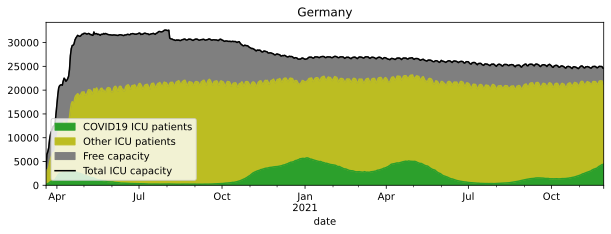

In [41]:
fig, ax = plt.subplots(figsize=(10,3))
ger_icu_df.plot.area(y=["used_covid", "used_non_covid", "free"], stacked=True, color=["tab:green", "tab:olive", "tab:grey"], label=icu_labels, ax=ax)
(ger_icu_df.used_covid+ger_icu_df.used_non_covid+ger_icu_df.free).plot(ax=ax, label="Total ICU capacity", c="black")
ax.set_title("Germany")
ax.set_xlabel("date")
ax.legend()

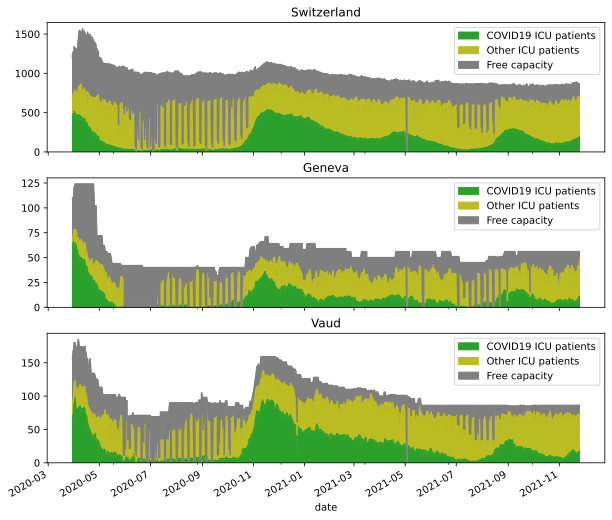

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
for ax, reg in zip(axs, ("CH", "GE", "VD")):
    reg_icu_df = ch_icu_df[ch_icu_df.canton == reg]
    reg_icu_df.plot.area(y=["used_covid", "used_non_covid", "free"], stacked=True, color=["tab:green", "tab:olive", "tab:grey"], label=icu_labels, ax=ax)
#     (reg_icu_df.used_covid+reg_icu_df.used_non_covid+reg_icu_df.free).plot(ax=ax, label="Total ICU capacity", c="black")
    ax.set_title({"CH": "Switzerland", "GE": "Geneva", "VD": "Vaud"}[reg])
    ax.set_xlabel("date")
    ax.legend()

## Incidences

In [43]:
inc_df = reduce(lambda l, r: l.join(r, how="outer"), [
    fr_dep_df[fr_dep_df.lib_dep == "Ain"][["tx_incid"]].rename(columns={"tx_incid": "Ain"}),
    fr_df[["tx_incid"]].rename(columns={"tx_incid": "France"}),
    ch_df[ch_df.geoRegion == "GE"][["inzsum7d"]].rename(columns={"inzsum7d": "Geneva"}),
    ch_df[ch_df.geoRegion == "VD"][["inzsum7d"]].rename(columns={"inzsum7d": "Vaud"}),
    ch_df[ch_df.geoRegion == "CH"][["inzsum7d"]].rename(columns={"inzsum7d": "Switzerland"}),
    ger_inc_df[ger_inc_df.location == "Deutschland"][["incidence_7d"]].rename(columns={"incidence_7d": "Germany"}),
])
inc_df.index = inc_df.index.date

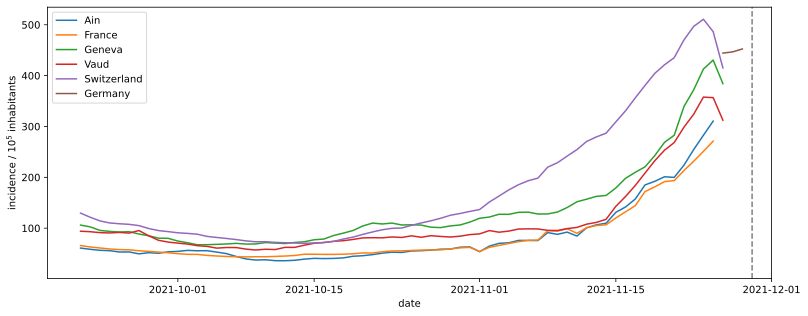

,Ain,France,Geneva,Vaud,Switzerland,Germany
2021-11-22,223.911836,213.360666,339.30,298.61,470.25,NaN
2021-11-23,254.659756,231.608451,372.08,324.14,496.78,NaN
2021-11-24,282.819980,251.048220,412.96,357.77,510.82,NaN
2021-11-25,310.523552,271.216589,430.54,356.67,486.44,NaN
2021-11-26,NaN,NaN,384.13,312.24,415.13,444.264160
2021-11-27,NaN,NaN,NaN,NaN,NaN,446.671711
2021-11-28,NaN,NaN,NaN,NaN,NaN,452.400769


In [44]:
fig, ax = plt.subplots(figsize=(13,5))
inc_df[inc_df.index > datetime.date.today() - datetime.timedelta(weeks=10)].plot(ax=ax)
# inc_df.tail(7*8).plot(ax=ax)
# ax.set_yscale("log")
ax.axvline(datetime.date.today(), ls="--", c="gray")
ax.set_ylim(bottom=1)
ax.set_xlim(right=datetime.date.today() + datetime.timedelta(days=2))
ax.set_xlabel("date")
ax.set_ylabel("incidence / $10^5$ inhabitants")
plt.show()
display(inc_df.tail(7))

In [32]:
idx = inc_df.notna()[::-1].idxmax()
tab_df = pd.DataFrame({"indicence": [inc_df.loc[i][c] for i, c in zip(idx, inc_df.columns)], 
                       "date": [humanize.naturaltime(dt) for dt in idx]}, index=inc_df.columns)
    
display(tab_df)

,indicence,date
Ain,310.523552,2021-11-25
France,271.216589,2021-11-25
Geneva,384.130000,2021-11-26
Vaud,312.240000,2021-11-26
Switzerland,415.130000,2021-11-26
Germany,452.400769,2021-11-28


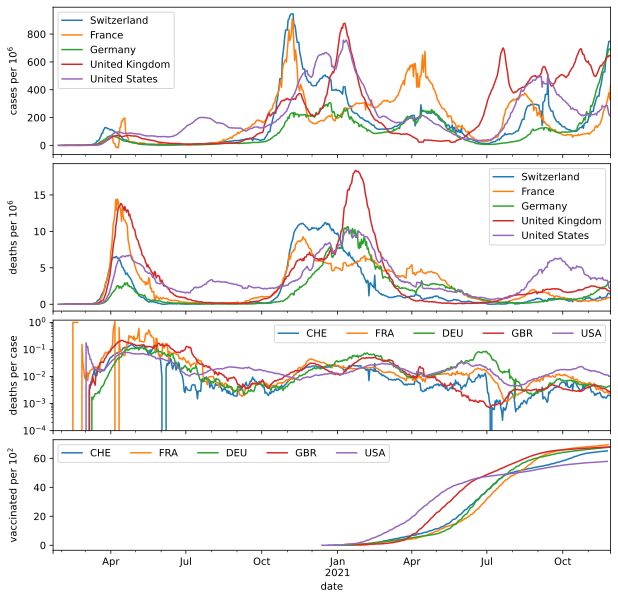

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 1, 0.75, 0.75], "hspace": 0.07}, sharex=True)
ax1, ax2, ax3, ax4 = axs
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
):
    cdf = df[df.iso_code == country]
    
    name = cdf.location[0]
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, label=name)
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, label=name)
   
    cdf.plot(y="death_ratio", ax=ax3, label=country)
    
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax4, label=f"{country}")
#     cdf.plot("date", "people_vaccinated_per_hundred", ax=ax3, ls="--", c=ax3.get_lines()[-1].get_color(), label=f"total")


# fr_dep_df[fr_dep_df.lib_dep == "Ain"].plot(y="tx_incid", ax=ax5, label="Ain")
# fr_df.plot(y="tx_incid", ax=ax5, label="France")
# ch_df[ch_df.geoRegion == "GE"].plot(y="inzsum7d", ax=ax5, label="Geneva")
# ch_df[ch_df.geoRegion == "VD"].plot(y="inzsum7d", ax=ax5, label="Vaud")
# ch_df[ch_df.geoRegion == "CH"].plot(y="inzsum7d", ax=ax5, label="Switzerland")
# inc_df.plot(ax=ax5)
# ax5.set_yscale("log")
# ax5.set_ylim(bottom=1)

ax4.set_xlabel("date")
# ax5.set_ylabel("cases / $10^5$ / 7d")

ax4.legend(ncol=5)
ax3.legend(ncol=5)

ax3.set_ylim(bottom=1e-4)
ax3.set_yscale("log")

ax1.set_ylabel("cases per $10^6$")
ax2.set_ylabel("deaths per $10^6$")
ax3.set_ylabel("deaths per case")
ax4.set_ylabel("vaccinated per $10^2$")

fig.align_ylabels()
# fig.tight_layout()
plt.show()

### Switzerland

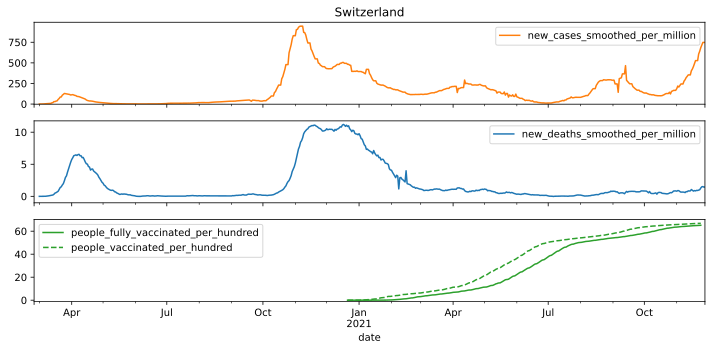

### France

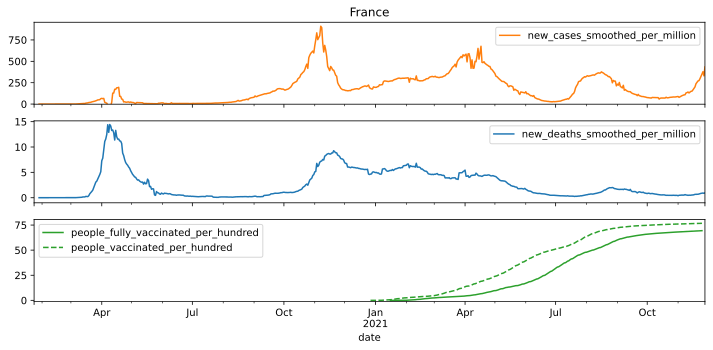

### Germany

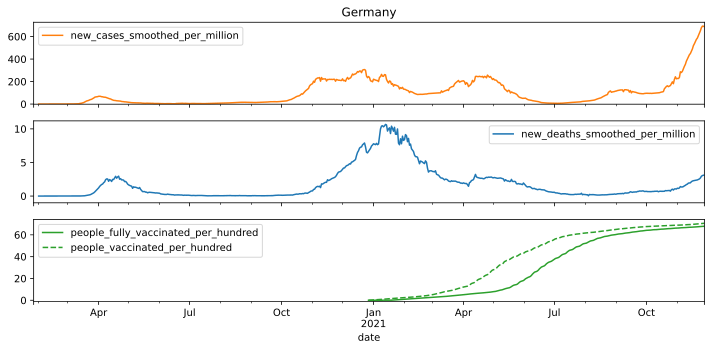

### United Kingdom

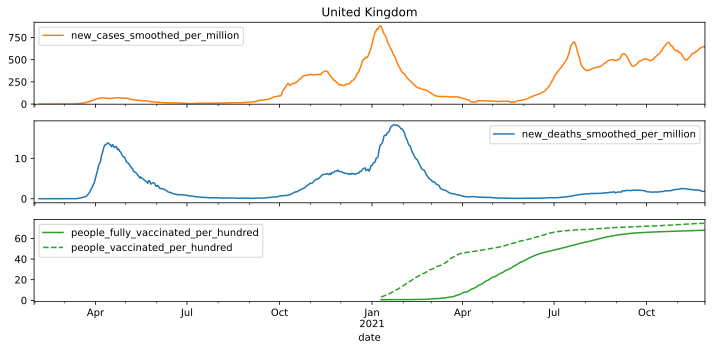

### United States

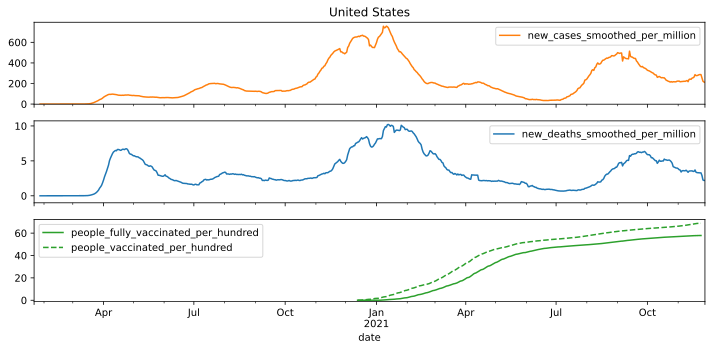

### Greece

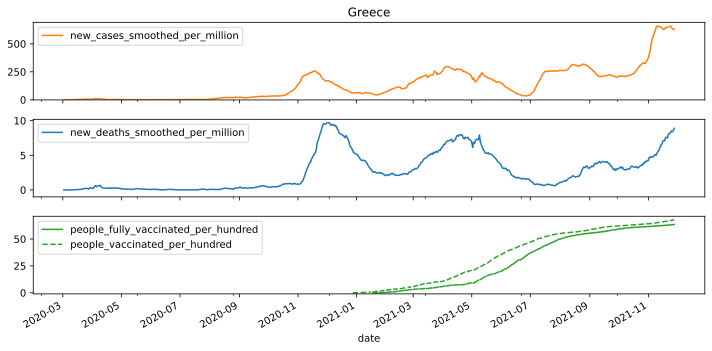

In [36]:
for country in (
    "CHE", 
    "FRA", 
    "DEU", 
    "GBR", 
    "USA",
    "GRC"
):
    cdf = df[df.iso_code == country]
    display(Markdown(f"### {cdf.location[0]}"))
    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
    ax1, ax2, ax3 = axs
    cdf.plot(y="new_cases_smoothed_per_million", ax=ax1, c="tab:orange")
    cdf.plot(y="new_deaths_smoothed_per_million", ax=ax2, c="tab:blue")
    cdf.plot(y="people_fully_vaccinated_per_hundred", ax=ax3, c="tab:green")
    cdf.plot(y="people_vaccinated_per_hundred", ax=ax3, c="tab:green", ls="--")
    
    for ax in axs:
        ax.set_ylim(bottom=-1)

    ax1.set_title(cdf.location[0])
    fig.tight_layout()
    plt.show()